# Problem statement

Sudden user engagement dip in August requires investigation.

# Possible causes of retention drop

1. Season of vacations.
2. New registrations decrease and some churn occurs.
3. A company may downsize its workforce, close a department, etc.
4. An application update that caused problems on certain devices or for certain features/region. Check the customer support logs.
5. Certain companies have problems and it's not a general trend, maybe it's even not our fault.

# Digging into the data

Importing all necessary packages.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import seaborn as sns
import plotly.express as px

Connecting to the database.

In [3]:
conn = sqlite3.connect('houston.db')
c = conn.cursor()

In [4]:
try:
    events = pd.read_csv('events.csv')
    users = pd.read_csv('users.csv')
    emails = pd.read_csv('emails.csv')
except:
    events = pd.read_csv('C:/Yevgenii/case_study_Houston/events.csv')
    users = pd.read_csv('C:/Yevgenii/case_study_Houston/users.csv')
    emails = pd.read_csv('C:/Yevgenii/case_study_Houston/emails.csv')

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       19066 non-null  float64
 1   created_at    19066 non-null  object 
 2   company_id    19066 non-null  float64
 3   language      19066 non-null  object 
 4   activated_at  9381 non-null   object 
 5   state         19066 non-null  object 
dtypes: float64(2), object(4)
memory usage: 893.8+ KB


In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      340832 non-null  float64
 1   occurred_at  340832 non-null  object 
 2   event_type   340832 non-null  object 
 3   event_name   340832 non-null  object 
 4   location     340832 non-null  object 
 5   device       340832 non-null  object 
 6   user_type    325255 non-null  float64
dtypes: float64(2), object(5)
memory usage: 18.2+ MB


In [7]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      90389 non-null  float64
 1   occurred_at  90389 non-null  object 
 2   action       90389 non-null  object 
 3   user_type    90389 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.8+ MB


- It appears that there are some missing values in the `activated_at` column of the `users` table. Perhaps not all users have activated their accounts yet. From the moment an account is created to the moment it is activated, it would be interesting to see how long it typically takes.

- In addition, there are some missing values in the `user_type` column of the `events` table. However, we do not think this column is necessary. Later, we'll make some checks.

# Users

Explore `users` data table.

Use SQL queries to examine it.

In [8]:
pd.read_sql('''
SELECT * FROM users
''', conn).head()

,user_id,created_at,company_id,language,activated_at,state
0,0,2013-01-01 20:59:39,5737,english,2013-01-01 21:01:07,active
1,1,2013-01-01 13:07:46,28,english,None,pending
2,2,2013-01-01 10:59:05,51,english,None,pending
3,3,2013-01-01 18:40:36,2800,german,2013-01-01 18:42:02,active
4,4,2013-01-01 14:37:51,5110,indian,2013-01-01 14:39:05,active


In [9]:
pd.read_sql('''
SELECT 
    COUNT(DISTINCT user_id) AS n_users
FROM 
    users
''', conn)

,n_users
0,19066


In [10]:
pd.read_sql('''
SELECT 
    COUNT(activated_at) AS n_users
FROM 
    users
''', conn)

,n_users
0,9381


In [11]:
pd.read_sql('''
SELECT 
    COUNT(DISTINCT company_id) AS n_companies
FROM 
    users
''', conn)

,n_companies
0,13198


In [12]:
pd.read_sql('''
SELECT 
    COUNT(DISTINCT language) AS n_languages
FROM 
    users
''', conn)

,n_languages
0,12


In [13]:
pd.read_sql('''
SELECT 
    language,
    COUNT(user_id) AS n_users
FROM 
    users
GROUP BY
    1
ORDER BY
    2 DESC
''', conn)

,language,n_users
0,english,9585
1,spanish,1771
2,french,1522
3,japanese,1324
4,german,1067
5,arabic,768
6,chinese,685
7,indian,583
8,russian,561
9,portugese,510


- A total of 19066 accounts have been created from 13198 different companies. However, only 9381 users have activated it. There are 12 different languages used by those accounts. English is the most popular language.

Let's look at how many users we acquired each month from `2013-01-01` to the present. 

In [14]:
new_accounts_per_month_created = pd.read_sql('''
SELECT 
    DATE(created_at, 'start of month') AS month,
    COUNT(user_id) AS n_users
FROM 
    users
GROUP BY 1
''', conn)
new_accounts_per_month_created.head()

,month,n_users
0,2013-01-01,332
1,2013-02-01,328
2,2013-03-01,383
3,2013-04-01,410
4,2013-05-01,486


In [15]:
new_accounts_per_month_activated = pd.read_sql('''
SELECT 
    DATE(activated_at, 'start of month') AS month,
    COUNT(user_id) AS n_users
FROM 
    users
WHERE DATE(activated_at, 'start of month') IS NOT NULL
GROUP BY 1

''', conn)
new_accounts_per_month_activated.head()

,month,n_users
0,2013-01-01,160
1,2013-02-01,160
2,2013-03-01,150
3,2013-04-01,181
4,2013-05-01,214


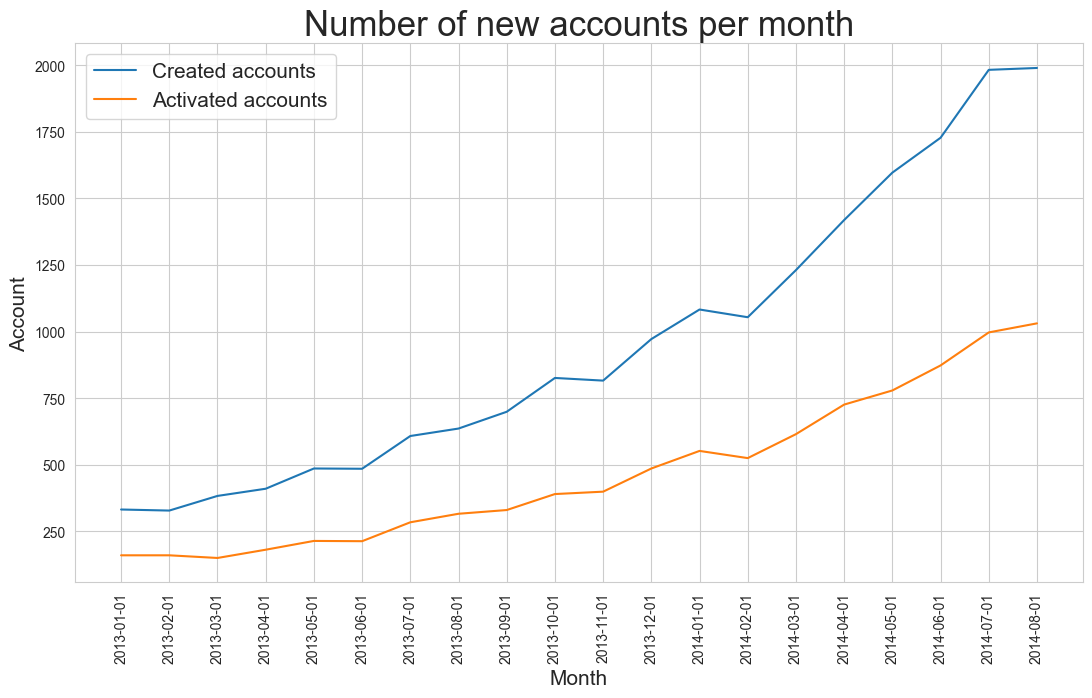

In [16]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Number of new accounts per month", fontdict={'size':25})
    ax.set_ylabel("Account", fontdict={'size':15})
    ax.set_xlabel("Month", fontdict={'size':15})
    
    sns.lineplot(data=new_accounts_per_month_created, y='n_users', x='month', label='Created accounts')
    sns.lineplot(data=new_accounts_per_month_activated, y='n_users', x='month', label='Activated accounts')
    plt.legend(fontsize=15)
    ax.set_xticklabels(new_accounts_per_month_created['month'], rotation=90, fontdict={'size':10})
    plt.show()

- Our monthly data shows an increasing gap between the number of newly created accounts and those that have been activated. In other words, we are seeing growth in the number of accounts created and in the number of accounts activated. However, the number of newly created accounts is growing faster than the number of activated accounts.

In [17]:
diff = pd.read_sql('''
SELECT 
    ROUND((JULIANDAY(activated_at) - JULIANDAY(created_at)) *24*60)  AS time_diff_min,
    COUNT(*) n_accounts
FROM 
    users
GROUP BY 
    1
''', conn)
diff

,time_diff_min,n_accounts
0,NaN,9685
1,1.0,5290
2,2.0,4091


- All users who activated their accounts completed the process within two minutes. Many others haven't been activated and haven't taken any actions, in other words haven't been engaged.

As we observed the engagement dip last month, the number of new accounts increased slightly compared to the previous month . What if we reviewed this on a weekly basis?

In [18]:
new_users_per_week_created = pd.read_sql('''
SELECT 
    DATE(created_at, 'Weekday 0') AS week,
    COUNT(user_id) AS n_users
FROM 
    users
GROUP BY 1
HAVING week >= '2014-05-01'
''', conn)
new_users_per_week_created

,week,n_users
0,2014-05-04,353
1,2014-05-11,350
2,2014-05-18,362
3,2014-05-25,371
4,2014-06-01,366
5,2014-06-08,390
6,2014-06-15,413
7,2014-06-22,421
8,2014-06-29,404
9,2014-07-06,405


In [19]:
new_users_per_week_activated = pd.read_sql('''
SELECT 
    DATE(created_at, 'Weekday 0') AS week,
    COUNT(user_id) AS n_users
FROM 
    users
WHERE activated_at IS NOT NULL
GROUP BY 1
HAVING week >= '2014-05-01'
''', conn)
new_users_per_week_activated

,week,n_users
0,2014-05-04,172
1,2014-05-11,160
2,2014-05-18,186
3,2014-05-25,177
4,2014-06-01,186
5,2014-06-08,197
6,2014-06-15,198
7,2014-06-22,222
8,2014-06-29,210
9,2014-07-06,199


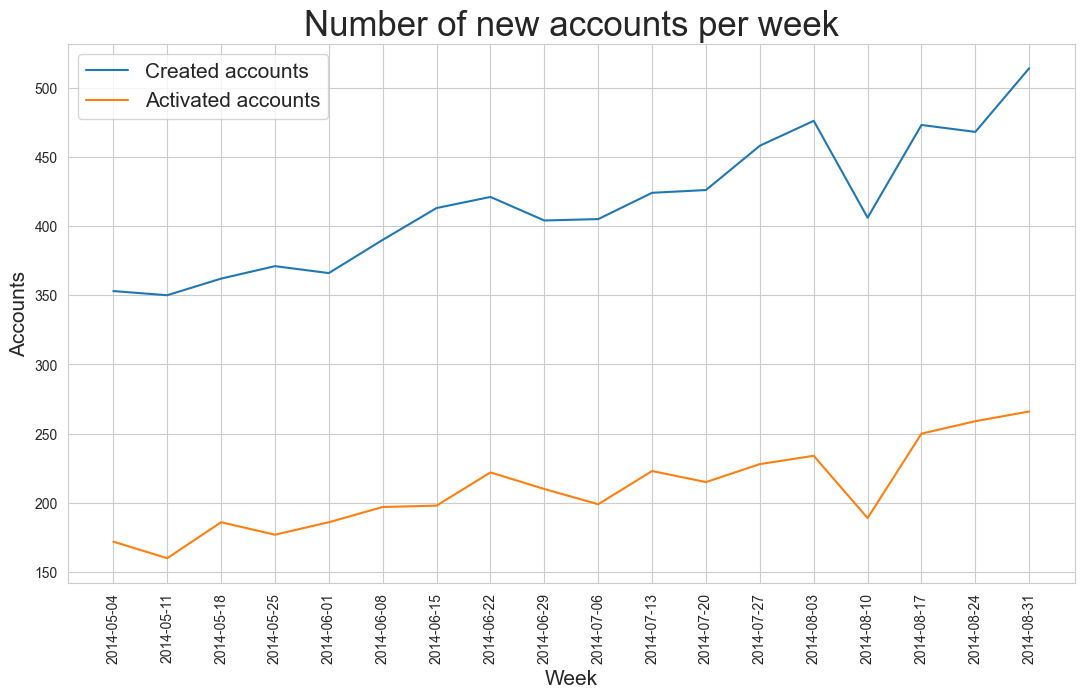

In [20]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Number of new accounts per week", fontdict={'size':25})
    ax.set_ylabel("Accounts", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    sns.lineplot(data=new_users_per_week_created, y='n_users', x='week', label = 'Created accounts')
    sns.lineplot(data=new_users_per_week_activated, y='n_users', x='week', label = 'Activated accounts')
    plt.legend(fontsize=15)
    ax.set_xticklabels(new_users_per_week_created['week'], rotation=90, fontdict={'size':10})
    plt.show()

- Our newly created accounts dropped significantly during the week of `2014-08-03` to `2014-08-09`. The numbers then begin to rise again and, by the end of the month, exceed those at the beginning of the month.

In [21]:
running_total = pd.read_sql('''
WITH new_users_per_week AS (
    SELECT 
        DATE(activated_at, 'Weekday 0') AS week,
        COUNT(user_id) AS n_users
    FROM 
        users
    GROUP BY 1
    HAVING week >= '2014-05-01'
    )
    
SELECT
    new_users_per_week.week,
    new_users_per_week.n_users,
    SUM(new_users_per_week.n_users) OVER(ORDER BY new_users_per_week.week ASC) AS running_total
FROM     
    new_users_per_week
ORDER BY new_users_per_week.week
''', conn)
running_total

,week,n_users,running_total
0,2014-05-04,172,172
1,2014-05-11,160,332
2,2014-05-18,186,518
3,2014-05-25,177,695
4,2014-06-01,186,881
5,2014-06-08,197,1078
6,2014-06-15,198,1276
7,2014-06-22,222,1498
8,2014-06-29,210,1708
9,2014-07-06,199,1907


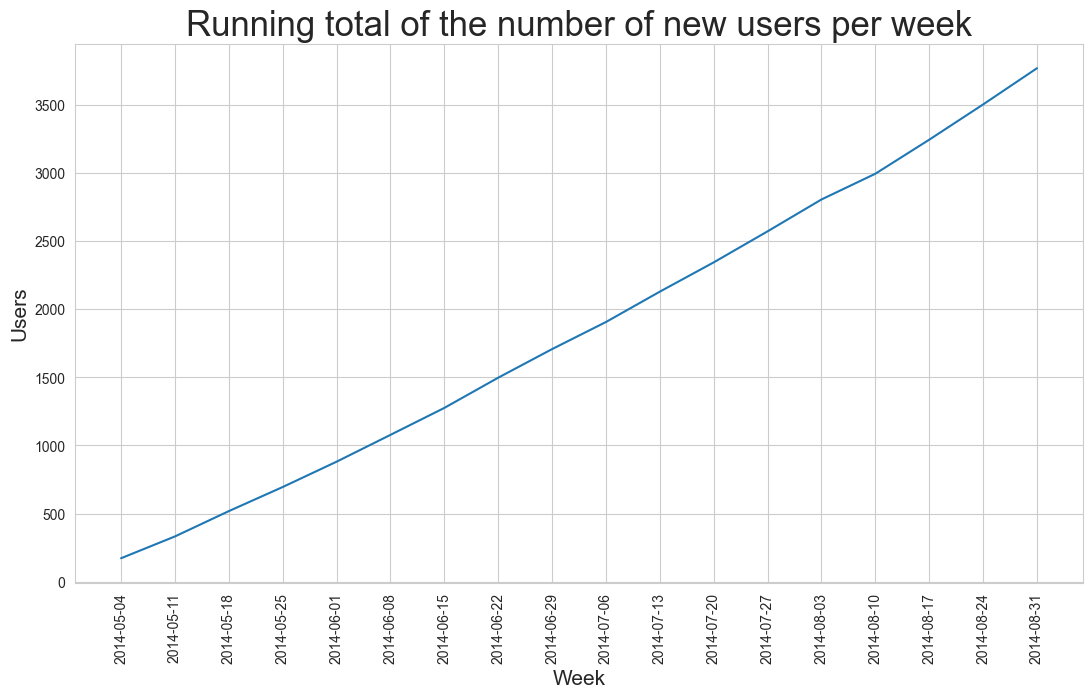

In [22]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Running total of the number of new users per week", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    sns.lineplot(data=running_total, y='running_total', x='week')
    ax.set_xticklabels(running_total['week'], rotation=90, fontdict={'size':10})
    plt.show()

Per company, check how many employees have created/activated accounts.

In [23]:
companies = pd.read_sql('''
SELECT 
    company_id,
    COUNT(user_id) AS n_users,
    COUNT(activated_at) AS n_activated_accounts,
    ROUND(COUNT(activated_at) * 100.0 / COUNT(user_id), 2) AS perc
FROM 
    users
GROUP BY 
    1
ORDER BY
    2 DESC, 4 DESC
''', conn)
companies.head(10)

,company_id,n_users,n_activated_accounts,perc
0,1,1036,510,49.23
1,2,477,231,48.43
2,3,307,158,51.47
3,4,220,97,44.09
4,5,172,87,50.58
5,6,151,80,52.98
6,8,129,64,49.61
7,7,122,61,50.00
8,9,96,49,51.04
9,10,86,38,44.19


In [24]:
companies = pd.read_sql('''
WITH perc AS (
SELECT 
    company_id,
    COUNT(user_id) AS n_users,
    COUNT(activated_at) AS n_activated_accounts,
    ROUND(COUNT(activated_at) * 100.0 / COUNT(user_id), 2) AS perc,
    CASE WHEN COUNT(user_id) = 10 THEN '10'
        WHEN COUNT(user_id) = 9 THEN '9'
        WHEN COUNT(user_id) = 8 THEN '8'
        WHEN COUNT(user_id) = 7 THEN '7'
        WHEN COUNT(user_id) = 6 THEN '6'
        WHEN COUNT(user_id) = 5 THEN '5'
        WHEN COUNT(user_id) = 4 THEN '4'
        WHEN COUNT(user_id) = 3 THEN '3'
        WHEN COUNT(user_id) = 2 THEN '2'
        WHEN COUNT(user_id) = 1 THEN '1'
        WHEN COUNT(user_id) < 100 THEN '<100'
        WHEN COUNT(user_id) >= 100 THEN '>=100'
        ELSE COUNT(user_id)
    END AS n_accounts_per_company  
FROM 
    users
GROUP BY 
    1
ORDER BY
    2 DESC
    )
    
SELECT 
    n_accounts_per_company,
    COUNT(company_id) AS n_companies
FROM 
    perc
GROUP BY 
    1
ORDER BY
    2 DESC
''', conn)
companies

,n_accounts_per_company,n_companies
0,1,12507
1,2,315
2,3,120
3,<100,70
4,4,64
5,6,33
6,5,30
7,8,17
8,7,16
9,10,13


In [25]:
companies = pd.read_sql('''
WITH perc AS (
SELECT 
    company_id,
    COUNT(user_id) AS n_users,
    COUNT(activated_at) AS n_activated_accounts,
    ROUND(COUNT(activated_at) * 100.0 / COUNT(user_id), 2) AS perc,
    CASE WHEN COUNT(activated_at) = 10 THEN '10'
        WHEN COUNT(activated_at) = 9 THEN '9'
        WHEN COUNT(activated_at) = 8 THEN '8'
        WHEN COUNT(activated_at) = 7 THEN '7'
        WHEN COUNT(activated_at) = 6 THEN '6'
        WHEN COUNT(activated_at) = 5 THEN '5'
        WHEN COUNT(activated_at) = 4 THEN '4'
        WHEN COUNT(activated_at) = 3 THEN '3'
        WHEN COUNT(activated_at) = 2 THEN '2'
        WHEN COUNT(activated_at) = 1 THEN '1'
        WHEN COUNT(activated_at) < 100 THEN '<100'
        WHEN COUNT(activated_at) >= 100 THEN '>=100'
        ELSE COUNT(activated_at)
    END AS n_activated_accounts_per_company  
FROM 
    users
WHERE activated_at IS NOT NULL
GROUP BY 
    1
ORDER BY
    2 DESC
    )
    
SELECT 
    n_activated_accounts_per_company,
    COUNT(company_id) AS n_companies
FROM 
    perc
GROUP BY 
    1
ORDER BY
    2 DESC
''', conn)
companies

,n_activated_accounts_per_company,n_companies
0,1,6365
1,2,181
2,3,59
3,<100,38
4,5,26
5,4,26
6,6,13
7,8,8
8,7,8
9,9,6


- In most companies, only half of their accounts are activated. There are 12507 companies with only one employee registered, but only 6365 accounts have been activated. This means that even those 6365 accounts are not really engaged.

In [26]:
pd.read_sql('''
SELECT 
    DISTINCT user_id,
    event_name,
    COUNT(*) AS n_events  
FROM 
    users u
JOIN events e
USING(user_id)
WHERE 
    activated_at IS NULL
GROUP BY 
    1

ORDER BY 
    3 DESC
''', conn).head(10)

,user_id,event_name,n_events
0,19033,create_user,3
1,19020,create_user,3
2,19006,create_user,3
3,18985,create_user,3
4,18978,create_user,3
5,18968,create_user,3
6,18964,create_user,3
7,18958,create_user,3
8,18921,create_user,3
9,18905,create_user,3


It appears that some users have created their accounts three times and have not yet activated them.

In [27]:
n_engagement_events = pd.read_sql('''
SELECT 
    DISTINCT user_id,
    COUNT(*) AS n_events  
FROM 
    events 
WHERE 
    event_type = 'engagement'
GROUP BY 
    1
HAVING COUNT(*) > 10
ORDER BY 
    2 DESC
''', conn)
n_engagement_events.head(10)

,user_id,n_events
0,3390,640
1,10276,561
2,3774,525
3,10498,512
4,2419,502
5,5633,500
6,8733,492
7,3720,487
8,12389,473
9,2398,461


In [28]:
len(n_engagement_events)

4824

Based on it, we can conclude that about 4824 users were engaged users (committed more than 10 actions).

Has anything changed in company growth (user signups)?


Cohorts analysis? to make it after events and mails

## Conclusion

We observe parabolic growth in the number of newly registered users each month, especially from February 2014. However, half of the accounts have never been activated and only 4824 accounts - out of 19066 created accounts - have completed at least 10 actions. 

We can therefore conclude that our social network is relatively new and people are still getting to know it. They don't really use it, since everyone works on-site and can share information by email, or in person. Although they registered, they didn't complete all the registration steps, so haven't taken any further action. Consequently, we are unable to show them advertising, they don't read engagement emails, and they don't pay for subscriptions.

# Events

Explore `events` data table.

In [29]:
pd.read_sql('''
SELECT * FROM events
''', conn).head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3


In [30]:
pd.read_sql('''
SELECT 
    COUNT(DISTINCT user_id) AS n_active_users
FROM 
    events
''', conn).head()

,n_active_users
0,9760


In [31]:
events_month = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'start of month') AS month,
    COUNT(*) AS n_events,
    COUNT(DISTINCT(user_id)) AS n_active_users   
FROM 
    events
GROUP BY 
    1
''', conn)
events_month

,month,n_events,n_active_users
0,2014-05-01,81802,3179
1,2014-06-01,82899,3460
2,2014-07-01,97042,4044
3,2014-08-01,79089,3754


In [32]:
engagement_events_month = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'start of month') AS month,
    COUNT(*) AS n_events,
    COUNT(DISTINCT(user_id)) AS n_active_users   
FROM 
    events
WHERE 
    event_type = 'engagement'
GROUP BY 
    1
''', conn)
engagement_events_month

,month,n_events,n_active_users
0,2014-05-01,77646,2361
1,2014-06-01,78306,2605
2,2014-07-01,91830,3058
3,2014-08-01,73793,2795


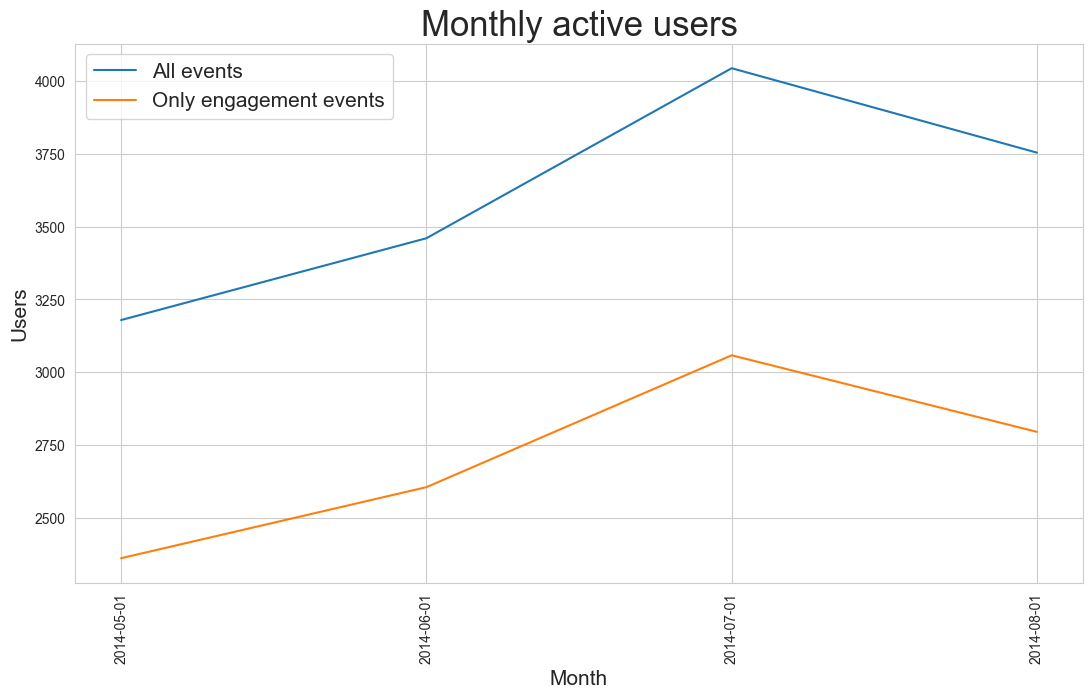

In [33]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Monthly active users", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Month", fontdict={'size':15})
    
    sns.lineplot(data=events_month, y='n_active_users', x='month', label='All events')
    sns.lineplot(data=engagement_events_month, y='n_active_users', x='month', label='Only engagement events')
    plt.legend(fontsize=15)
    ax.set_xticklabels(events_month['month'], rotation=90, fontdict={'size':10})
    plt.show()

- In August, we saw a sharp drop in the number of events compared to July. In fact, it's lower than May. Although the number of active users decreased, they still exceeded those of May and June. As a result, fewer users were engaged and fewer actions were taken by those who remained active. It is the same for engagement events as well.

In [34]:
events_week = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week,
    COUNT(*) AS n_events,
    COUNT(DISTINCT user_id) AS n_unique_users,
    ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT(user_id))) AS events_per_user
FROM
    events
WHERE
    event_type = 'engagement'
GROUP BY 
    1
''', conn)
events_week

,week,n_events,n_unique_users,events_per_user
0,2014-05-04,8709,701,12.0
1,2014-05-11,17532,1054,17.0
2,2014-05-18,17047,1094,16.0
3,2014-05-25,17890,1147,16.0
4,2014-06-01,17193,1113,15.0
5,2014-06-08,18608,1173,16.0
6,2014-06-15,18233,1219,15.0
7,2014-06-22,18976,1263,15.0
8,2014-06-29,18859,1249,15.0
9,2014-07-06,18959,1271,15.0


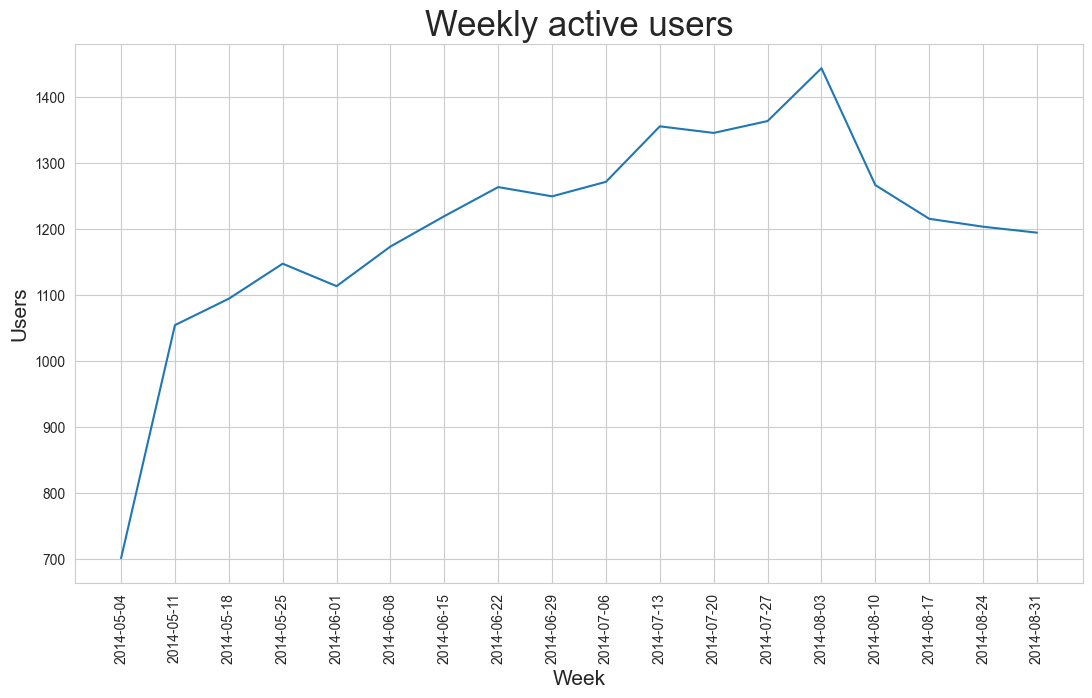

In [35]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active users", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    sns.lineplot(data=events_week, y='n_unique_users', x='week')
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

- Each week, the average user performs 15 engagement actions. It has been found that the number of actions per user was 13-14 in August, confirming our previous findings of fewer actions by active users, along with a drop in the number of users who continued to use the service.

### Event names

See which events we have for the event types `signup_flow` and `engagement`.

In [36]:
pd.read_sql('''
SELECT 
    DISTINCT event_type, 
    event_name 
FROM 
    events
WHERE 
    event_type = 'signup_flow'
''', conn)

,event_type,event_name
0,signup_flow,create_user
1,signup_flow,enter_email
2,signup_flow,enter_info
3,signup_flow,complete_signup


In [37]:
pd.read_sql('''
SELECT 
    DISTINCT event_type, 
    event_name 
FROM 
    events
WHERE 
    event_type = 'engagement'
''', conn)

,event_type,event_name
0,engagement,login
1,engagement,home_page
2,engagement,like_message
3,engagement,view_inbox
4,engagement,search_run
5,engagement,send_message
6,engagement,search_autocomplete
7,engagement,search_click_result_10
8,engagement,search_click_result_7
9,engagement,search_click_result_8


Using the `CASE` statement in `SELECT`, we can assemble all the events associated with the search.

In [38]:
events_engagement = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week,
    event_type,
    CASE 
        WHEN event_name LIKE 'search%' 
        THEN 'search'
        ELSE event_name
    END AS event_name,
    COUNT(event_type) AS n_events,
    COUNT(DISTINCT(user_id)) AS n_unique_users_commited_actions   
FROM 
    events
WHERE event_type = 'engagement'
GROUP BY 
    1, 2, 3
''', conn)
events_engagement.head(10)

,week,event_type,event_name,n_events,n_unique_users_commited_actions
0,2014-05-04,engagement,home_page,2546,646
1,2014-05-04,engagement,like_message,1657,564
2,2014-05-04,engagement,login,967,701
3,2014-05-04,engagement,search,1125,251
4,2014-05-04,engagement,send_message,904,433
5,2014-05-04,engagement,view_inbox,1510,532
6,2014-05-11,engagement,home_page,5113,972
7,2014-05-11,engagement,like_message,3382,874
8,2014-05-11,engagement,login,1999,1054
9,2014-05-11,engagement,search,2162,467


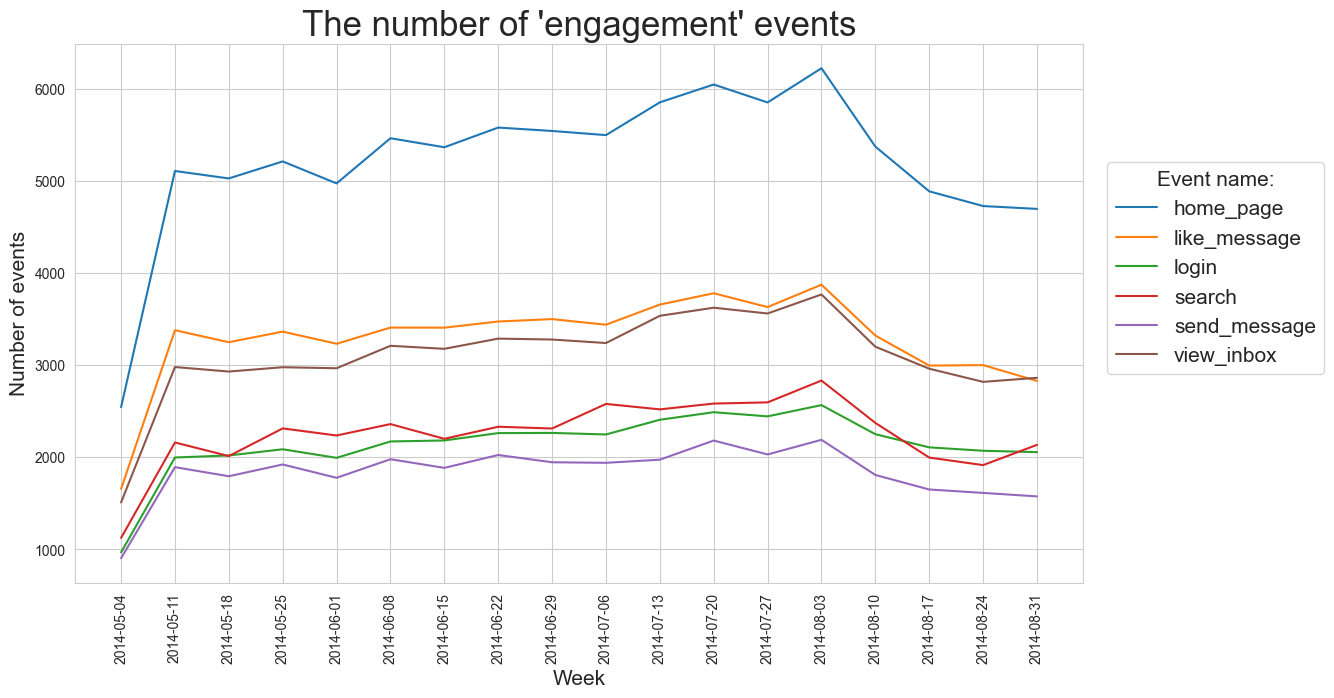

In [39]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("The number of 'engagement' events", fontdict={'size':25})
    ax.set_ylabel("Number of events", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=events_engagement, y='n_events', x='week', hue='event_name')
    plt.legend(title='Event name:', title_fontsize=15, 
               fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

- The `home_page` is visited the most often by users. After that, they view their inbox and like their message. There are less frequent events such as `search`, `login`, and `send_message`. Our `login` event can be explained - typically you log in only once during the day, or during a session.

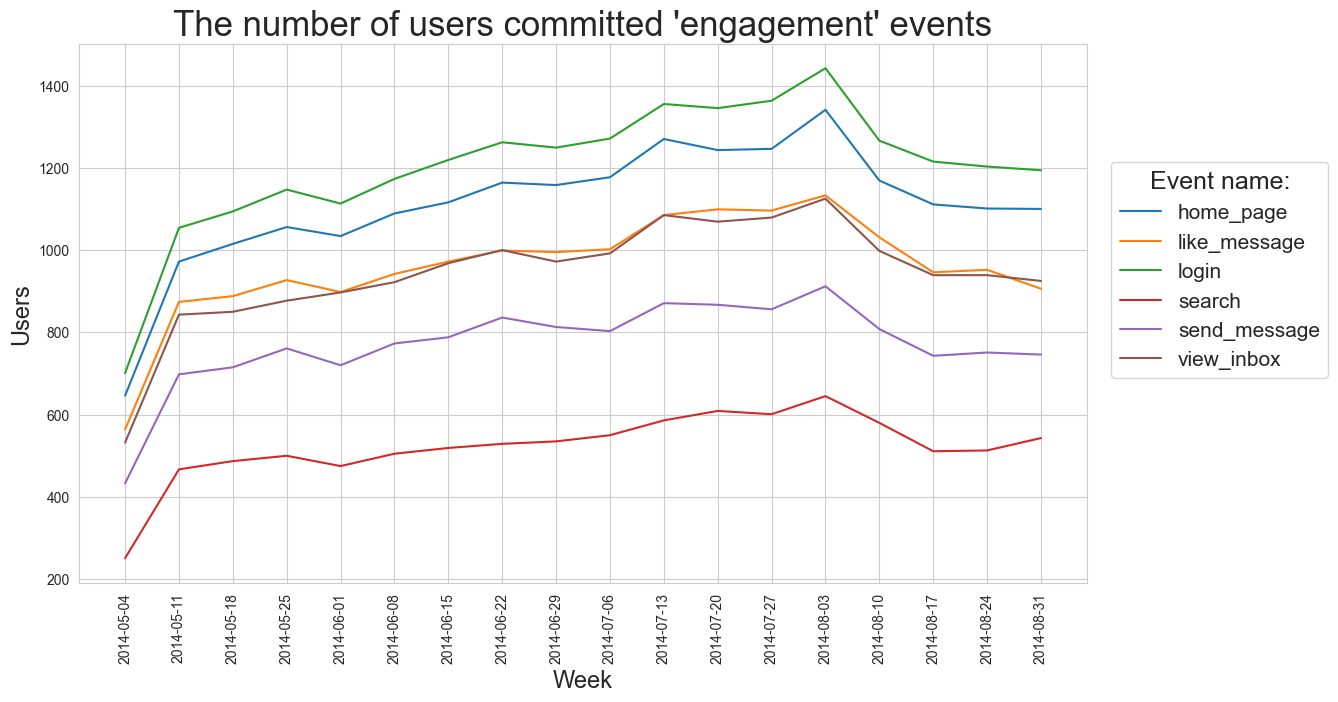

In [40]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("The number of users committed 'engagement' events", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':17})
    ax.set_xlabel("Week", fontdict={'size':17})
    
    ax = sns.lineplot(data=events_engagement, y='n_unique_users_commited_actions', x='week', hue='event_name')
    plt.legend(title='Event name:', title_fontsize=18, 
               fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

- Here we confirm it - everyone requires authentication before attempting other actions, but not everyone sees their home page or likes their message.

- Both engagement events performed and users engaged decreased in August within every `event_name`. Therefore, there were no problems with some features being less used.

Take a look at the `signup_flow` events.

In [41]:
events_signup_flow = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week,
    event_type,
    event_name,
    COUNT(event_type) AS n_events,
    COUNT(DISTINCT(user_id)) AS n_unique_users_commited_actions   
FROM 
    events
WHERE event_type = 'signup_flow'
GROUP BY 
    1, 2, 3
''', conn)
events_signup_flow.head()

,week,event_type,event_name,n_events,n_unique_users_commited_actions
0,2014-05-04,signup_flow,complete_signup,81,81
1,2014-05-04,signup_flow,create_user,171,171
2,2014-05-04,signup_flow,enter_email,102,102
3,2014-05-04,signup_flow,enter_info,86,86
4,2014-05-11,signup_flow,complete_signup,160,160


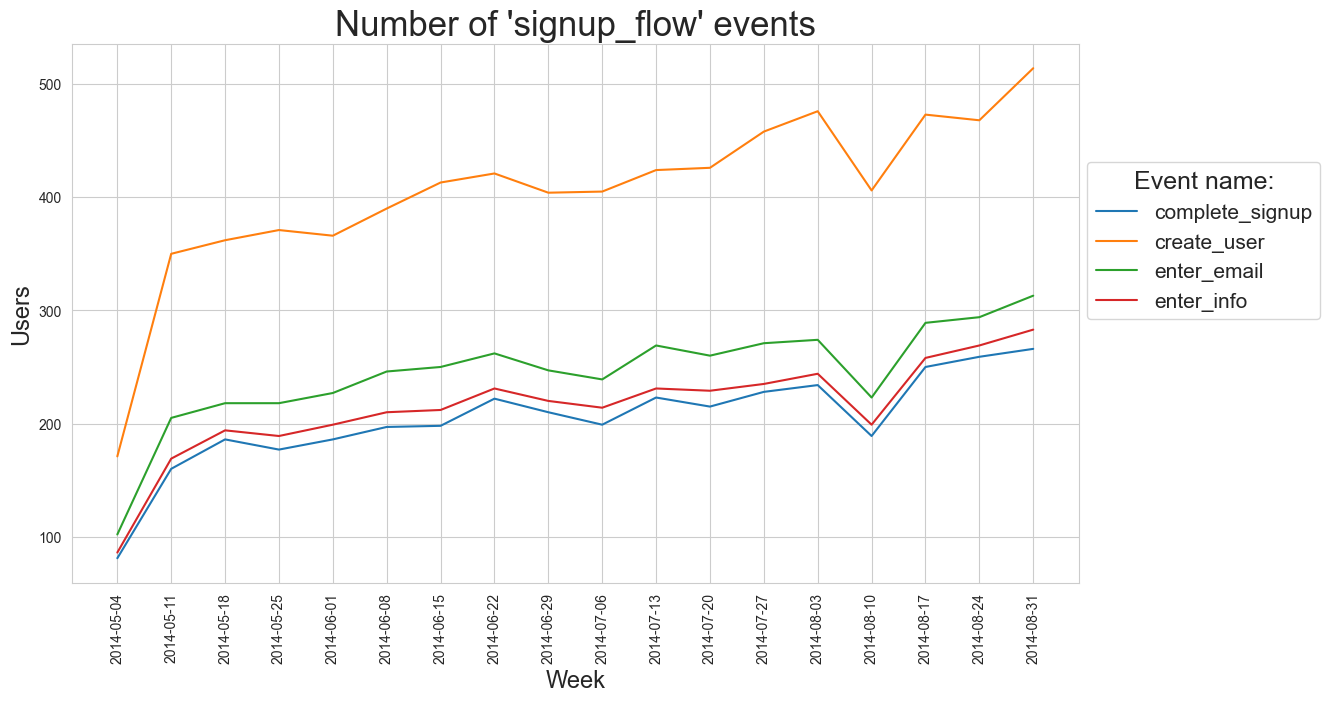

In [42]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Number of 'signup_flow' events", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':17})
    ax.set_xlabel("Week", fontdict={'size':17})
    
    ax = sns.lineplot(data=events_signup_flow, y='n_events', x='week', hue='event_name')
    plt.legend(title='Event name:', title_fontsize=18, 
               fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

#### Conclusion

- In early August, users' sign ups did drop for a week, but they soon resumed growing. However, some users fail to complete the registration process after they create an account, not entering their email address and other information. Moreover, even those who completed did not use the network at all, in other words, haven't been engaged yet.

- Despite the fact that company growth (number of new users signing up) has not changed, we do have questions about its quality. Our concern is that they do not remain engaged.

- Additionally, it's interesting what happened between `August 3, 2014`, and `August 9, 2014`.

### Location

The following table shows how users are distributed by country.

In [43]:
n_users_located_in_country = pd.read_sql('''
SELECT 
    DISTINCT location,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
GROUP BY 
    1
ORDER BY 
    2 DESC
''', conn)
n_users_located_in_country.head(10)

,location,n_users
0,United States,2762
1,Japan,745
2,Germany,606
3,France,468
4,United Kingdom,448
5,Italy,361
6,Russia,352
7,Brazil,335
8,India,306
9,Canada,289


- The most users are in the USA. However, it does not show how it has changed over time.

We'll plot a graph showing the weekly active users of the top 5 countries by users.

In [44]:
location = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    location, 
    COUNT(DISTINCT user_id) AS n_unique_users_made_actions
FROM 
    events 
WHERE 
    location IN (
        'United States', 'Japan', 'Germany', 
        'France', 'United Kingdom' 
      ) 
GROUP BY 
    1, 2 
ORDER BY 
    1 ASC, 2 DESC
''', conn)
location.head()

,week,location,n_unique_users_made_actions
0,2014-05-04,United States,230
1,2014-05-04,United Kingdom,41
2,2014-05-04,Japan,50
3,2014-05-04,Germany,50
4,2014-05-04,France,41


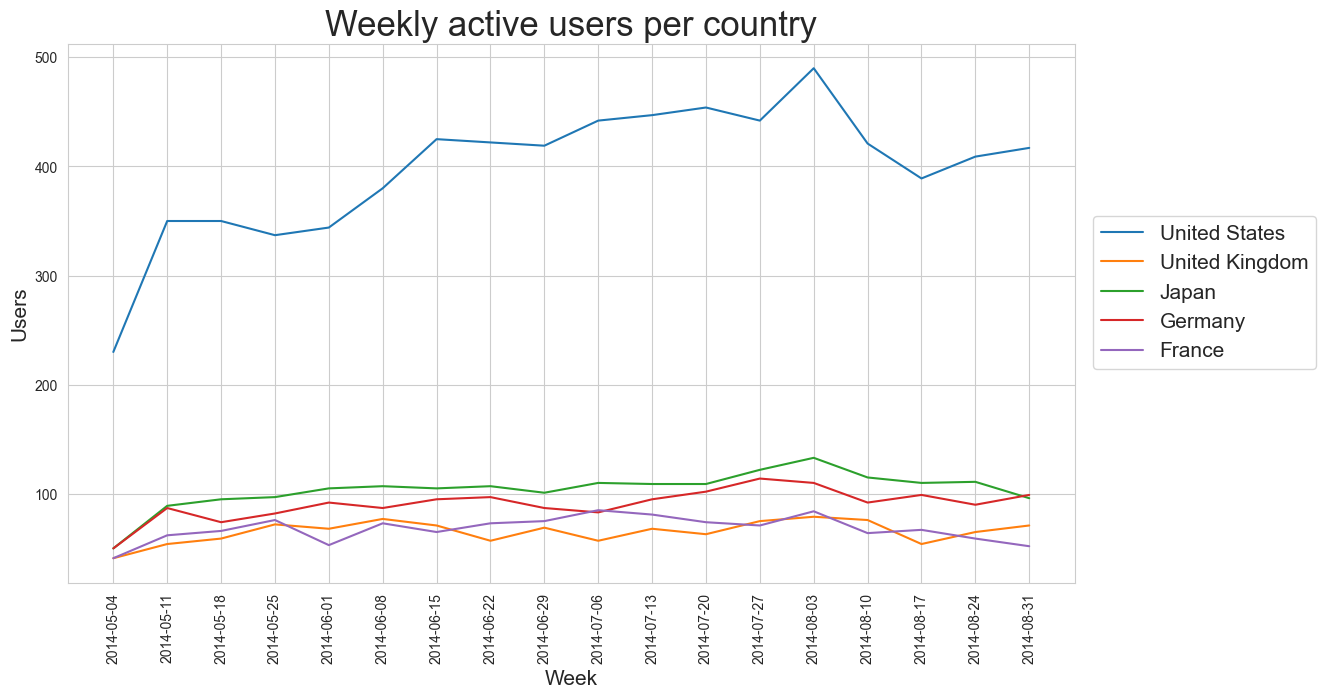

In [45]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active users per country", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=location, y='n_unique_users_made_actions', x='week', hue='location')
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.7))
    plt.show()

- There is a sharp decrease in user activity in the United States. A new user's quality or vacations might have played a role.

In [46]:
location_inactive_users = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    location, 
    COUNT(DISTINCT user_id) AS n_unique_users_made_actions
FROM 
    users u
JOIN events e
USING(user_id)
WHERE 
    location IN (
        'United States', 'Japan', 'Germany', 
        'France', 'United Kingdom' 
      ) 
    AND state = 'pending'
GROUP BY 
    1, 2 
ORDER BY 
    1 ASC, 2 DESC
''', conn)
location_inactive_users.head()

,week,location,n_unique_users_made_actions
0,2014-05-04,United States,27
1,2014-05-04,United Kingdom,8
2,2014-05-04,Japan,3
3,2014-05-04,Germany,8
4,2014-05-04,France,7


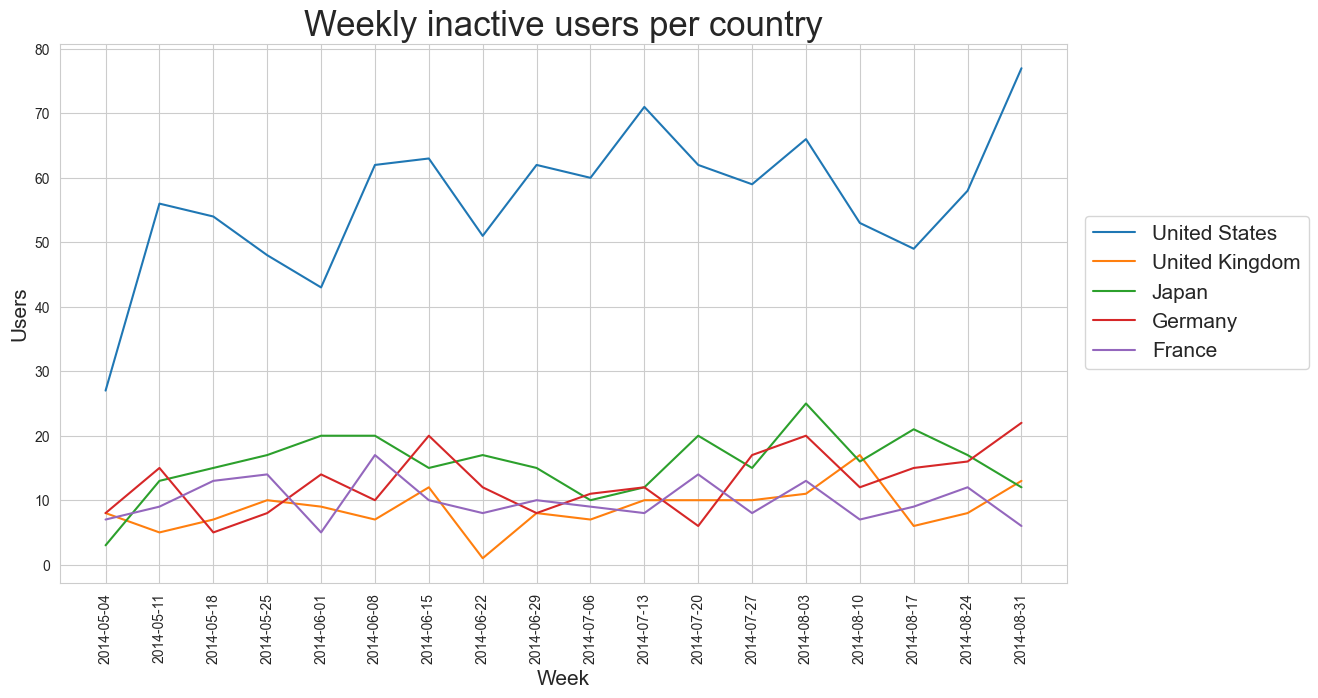

In [47]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly inactive users per country", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=location_inactive_users, y='n_unique_users_made_actions', x='week', hue='location')
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.7))
    plt.show()

- Here we see what we already knew - the number of inactivated accounts is growing, but not at the same rate. In the United States, it seems to be growing faster.

#### Conclusion

### Device

Can we localize the problem into a specific device type?

In [48]:
n_users_per_devices = pd.read_sql('''
SELECT 
    DISTINCT device,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
GROUP BY
    1
ORDER BY 
    2 DESC
''', conn)
n_users_per_devices

,device,n_users
0,macbook pro,2559
1,lenovo thinkpad,1727
2,iphone 5,1291
3,macbook air,1268
4,samsung galaxy s4,1027
5,dell inspiron notebook,848
6,nexus 5,819
7,iphone 5s,798
8,ipad air,590
9,iphone 4s,531


All the devices of the same brand should be grouped by type - portable/ smartphones, PC/laptops. Use `CASE` statement. Take only first 10 brands.

In [49]:
devices = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    CASE 
        WHEN device LIKE 'macbook%' THEN 'macbook' 
        WHEN device LIKE 'iphone%' THEN 'iphone' 
        WHEN device LIKE 'sam%' THEN 'samsung' 
        WHEN device LIKE 'dell%' THEN 'dell' 
        WHEN device LIKE 'nexus%' THEN 'nexus' 
        WHEN device LIKE 'acer%' THEN 'acer' 
        WHEN device LIKE 'ipad%' THEN 'ipad' 
        WHEN device LIKE 'asus%' THEN 'asus' 
        WHEN device LIKE 'hp%' THEN 'hp' 
        WHEN device LIKE 'lenovo%' THEN 'lenovo' 
        ELSE device
    END AS device,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
WHERE 
    device LIKE 'macbook%' OR device LIKE 'iphone%' OR device LIKE 'sam%' OR device LIKE 'dell%' 
        OR device LIKE 'nexus%' OR device LIKE 'acer%' OR device LIKE 'ipad%' 
        OR device LIKE 'asus%' OR device LIKE 'hp%' OR device LIKE 'lenovo%'
GROUP BY
    1, 2

ORDER BY 
    1
''', conn)
devices.head(20)

,week,device,n_users
0,2014-05-04,acer,39
1,2014-05-04,asus,26
2,2014-05-04,dell,74
3,2014-05-04,hp,18
4,2014-05-04,ipad,54
5,2014-05-04,iphone,151
6,2014-05-04,lenovo,100
7,2014-05-04,macbook,230
8,2014-05-04,nexus,87
9,2014-05-04,samsung,77


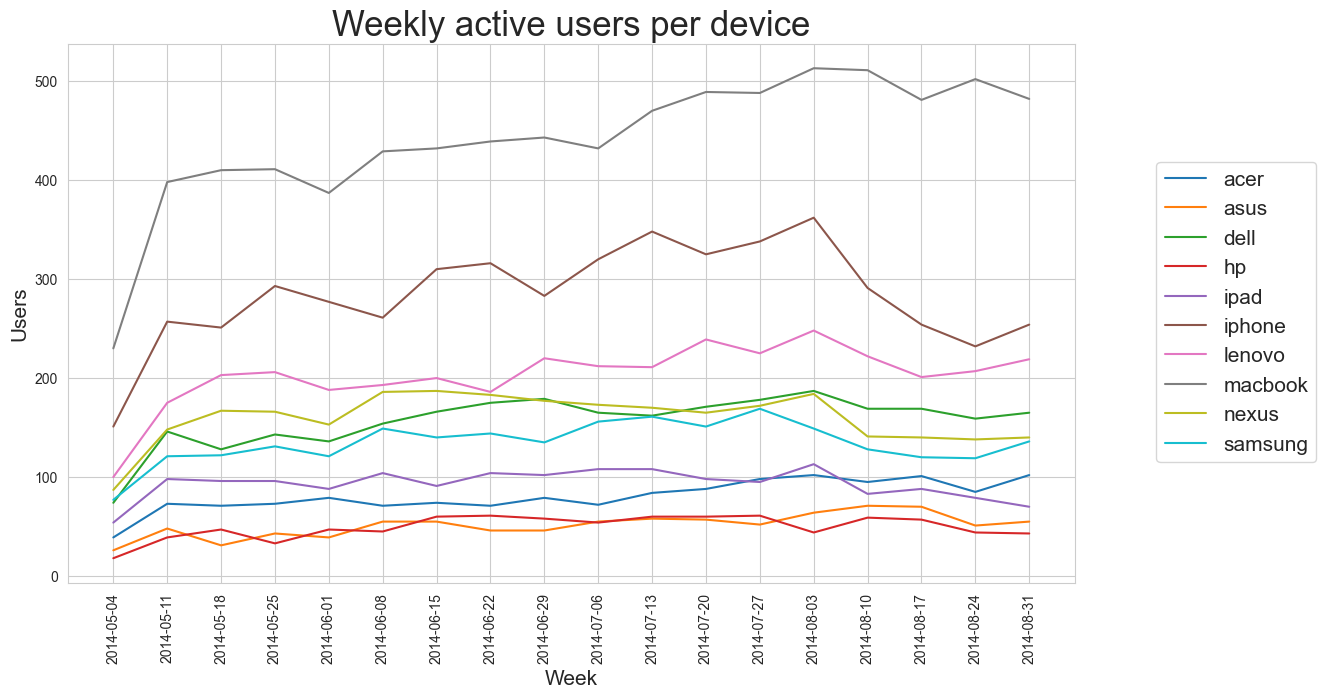

In [50]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active users per device", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=devices, y='n_users', x='week', hue='device')
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

- The biggest drop in engagement is among `iphone` users. `Macbook`, which has the most users, doesn't show such a dip.

I find it interesting to see how different devices are broken down by country.

In [51]:
devices_per_location = pd.read_sql('''
SELECT 
    location,
    CASE 
        WHEN device LIKE 'macbook%' THEN 'macbook' 
        WHEN device LIKE 'iphone%' THEN 'iphone' 
        WHEN device LIKE 'sam%' THEN 'samsung' 
        WHEN device LIKE 'dell%' THEN 'dell' 
        WHEN device LIKE 'nexus%' THEN 'nexus' 
        WHEN device LIKE 'acer%' THEN 'acer' 
        WHEN device LIKE 'ipad%' THEN 'ipad' 
        WHEN device LIKE 'asus%' THEN 'asus' 
        WHEN device LIKE 'hp%' THEN 'hp' 
        WHEN device LIKE 'lenovo%' THEN 'lenovo' 
        ELSE device
    END AS device,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
WHERE 
    (device LIKE 'macbook%' OR device LIKE 'iphone%' OR device LIKE 'sam%' OR device LIKE 'dell%' 
        OR device LIKE 'nexus%' OR device LIKE 'acer%' OR device LIKE 'ipad%' 
        OR device LIKE 'asus%' OR device LIKE 'hp%' OR device LIKE 'lenovo%')
    AND location IN (
        'United States', 'Japan', 'Germany', 
        'France', 'United Kingdom' 
        )
GROUP BY
    1, 2
ORDER BY 
    1 DESC, 3 DESC
''', conn)
devices_per_location.head(20)

,location,device,n_users
0,United States,macbook,1000
1,United States,iphone,779
2,United States,lenovo,497
3,United States,nexus,414
4,United States,dell,355
5,United States,samsung,351
6,United States,ipad,311
7,United States,acer,206
8,United States,asus,132
9,United States,hp,126


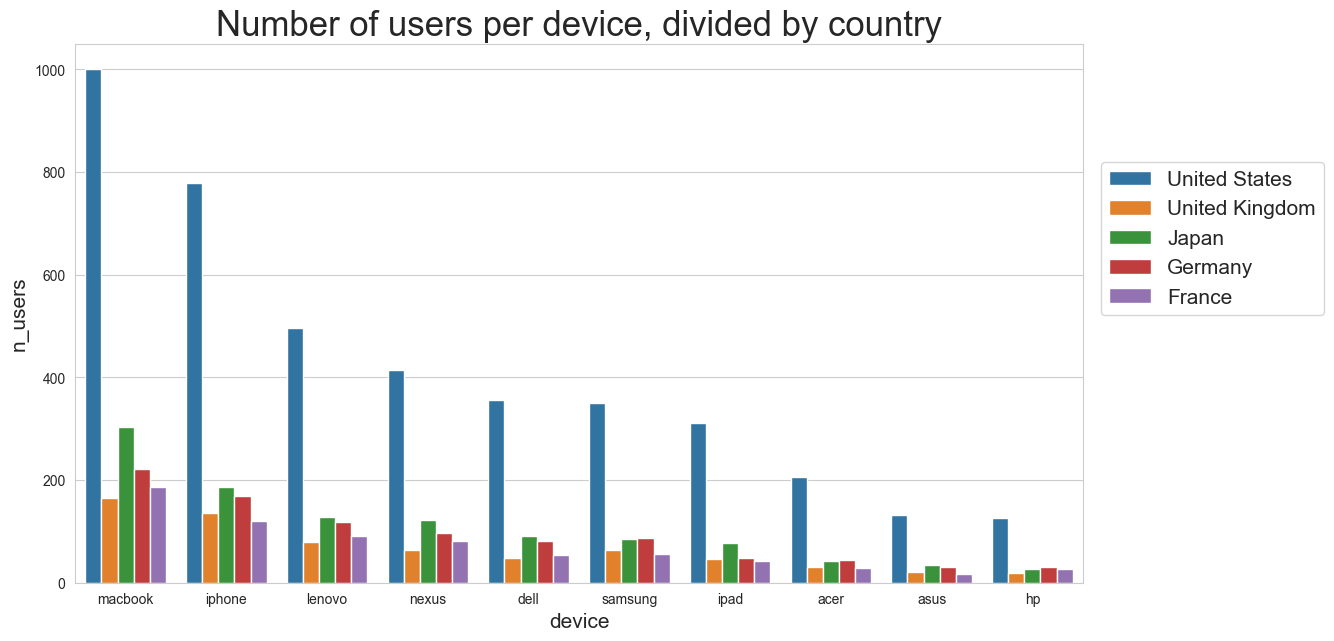

In [52]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Number of users per device, divided by country", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Device", fontdict={'size':15})
    
    ax = sns.barplot(data=devices_per_location, y='n_users', x='device', hue='location')
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    plt.show()

- In every country, it's pretty much the same order.

Wouldn't it be interesting to know how many people are active on each device per week, broken down by country? Are we going to see a difference?

In [53]:
macbook = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    location,
    CASE 
        WHEN device LIKE 'macbook%' THEN 'macbook'  
        ELSE device
    END AS device,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
WHERE 
    device LIKE 'macbook%'
    AND location IN (
        'United States', 'Japan', 'Germany', 
        'France', 'United Kingdom' 
        )
GROUP BY
    1, 2
ORDER BY 
    1 ASC, 2 DESC, 4 DESC
''', conn)
macbook.head(10)

,week,location,device,n_users
0,2014-05-04,United States,macbook,67
1,2014-05-04,United Kingdom,macbook,9
2,2014-05-04,Japan,macbook,19
3,2014-05-04,Germany,macbook,11
4,2014-05-04,France,macbook,13
5,2014-05-11,United States,macbook,112
6,2014-05-11,United Kingdom,macbook,16
7,2014-05-11,Japan,macbook,31
8,2014-05-11,Germany,macbook,25
9,2014-05-11,France,macbook,20


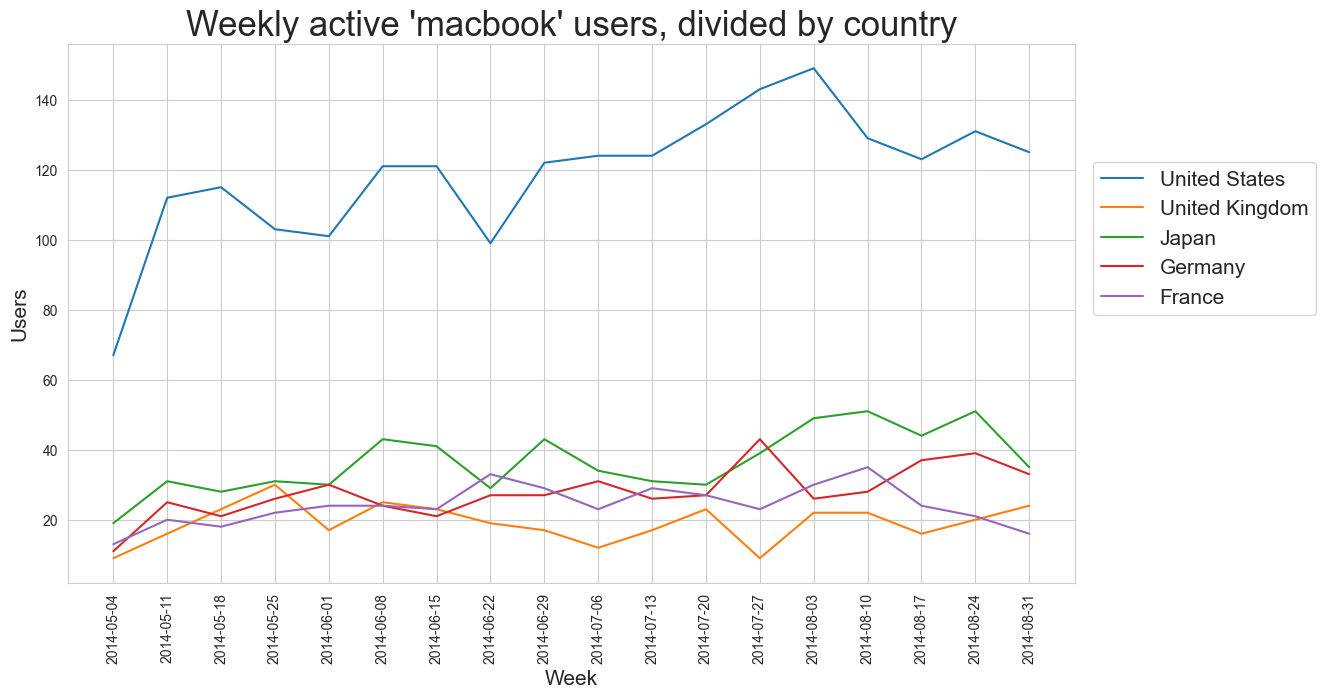

In [54]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active 'macbook' users, divided by country", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=macbook, y='n_users', x='week', hue='location')
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    plt.show()

- Among `macbook` users, we see a slight decline in the USA, but it is offset by growth in Germany and the United Kingdom.

In [55]:
iphone = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    location,
    CASE 
        WHEN device LIKE 'iphone%' THEN 'iphone'  
        ELSE device
    END AS device,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
WHERE 
    device LIKE 'iphone%'
    AND location IN (
        'United States', 'Japan', 'Germany', 
        'France', 'United Kingdom' 
        )
GROUP BY
    1, 2
ORDER BY 
    1 ASC, 2 DESC, 4 DESC
''', conn)
iphone.head(10)

,week,location,device,n_users
0,2014-05-04,United States,iphone,40
1,2014-05-04,United Kingdom,iphone,9
2,2014-05-04,Japan,iphone,7
3,2014-05-04,Germany,iphone,10
4,2014-05-04,France,iphone,7
5,2014-05-11,United States,iphone,74
6,2014-05-11,United Kingdom,iphone,12
7,2014-05-11,Japan,iphone,14
8,2014-05-11,Germany,iphone,20
9,2014-05-11,France,iphone,13


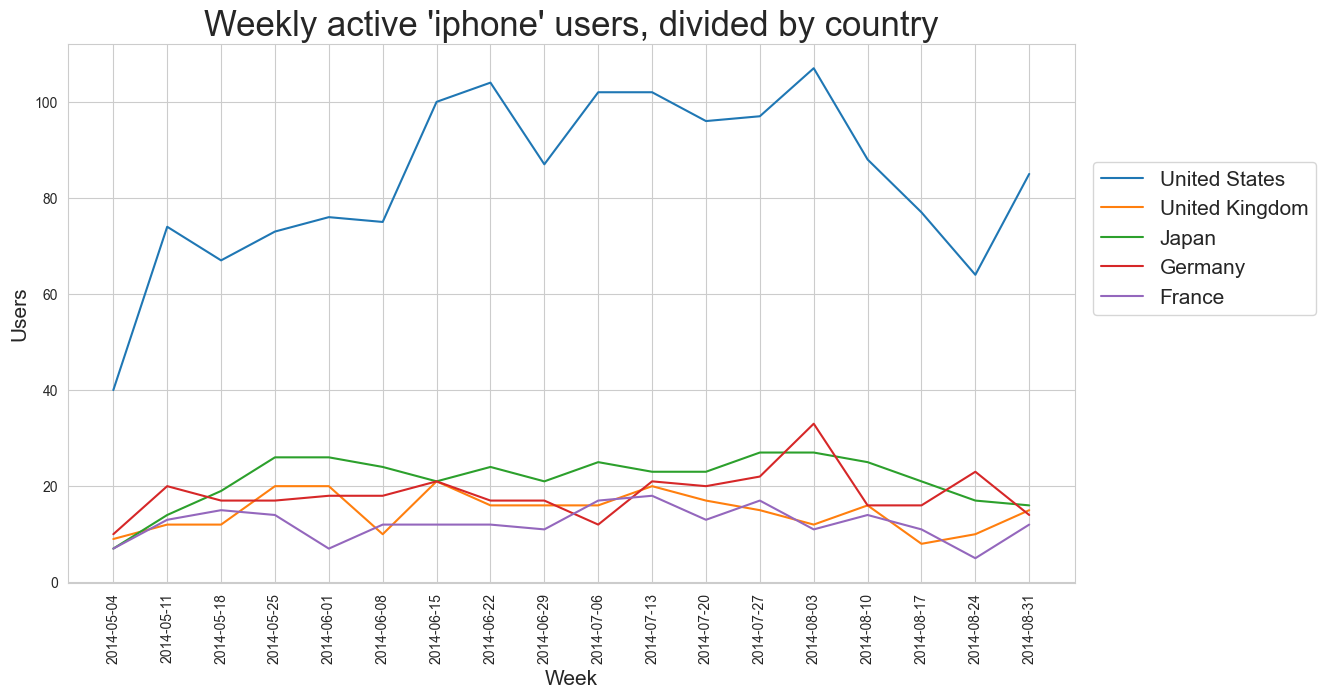

In [56]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active 'iphone' users, divided by country", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=iphone, y='n_users', x='week', hue='location')
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    plt.show()

There was a decrease in engagement among `iphone` users in every country in August.

In [57]:
lenovo = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    location,
    CASE 
        WHEN device LIKE 'lenovo%' THEN 'lenovo'  
        ELSE device
    END AS device,
    COUNT(DISTINCT user_id) AS n_users
FROM 
    events
WHERE 
    device LIKE 'lenovo%'
    AND location IN (
        'United States', 'Japan', 'Germany', 
        'France', 'United Kingdom' 
        )
GROUP BY
    1, 2
ORDER BY 
    1 ASC, 2 DESC, 4 DESC
''', conn)
lenovo.head(10)

,week,location,device,n_users
0,2014-05-04,United States,lenovo,28
1,2014-05-04,United Kingdom,lenovo,4
2,2014-05-04,Japan,lenovo,6
3,2014-05-04,Germany,lenovo,12
4,2014-05-04,France,lenovo,7
5,2014-05-11,United States,lenovo,44
6,2014-05-11,United Kingdom,lenovo,6
7,2014-05-11,Japan,lenovo,13
8,2014-05-11,Germany,lenovo,13
9,2014-05-11,France,lenovo,8


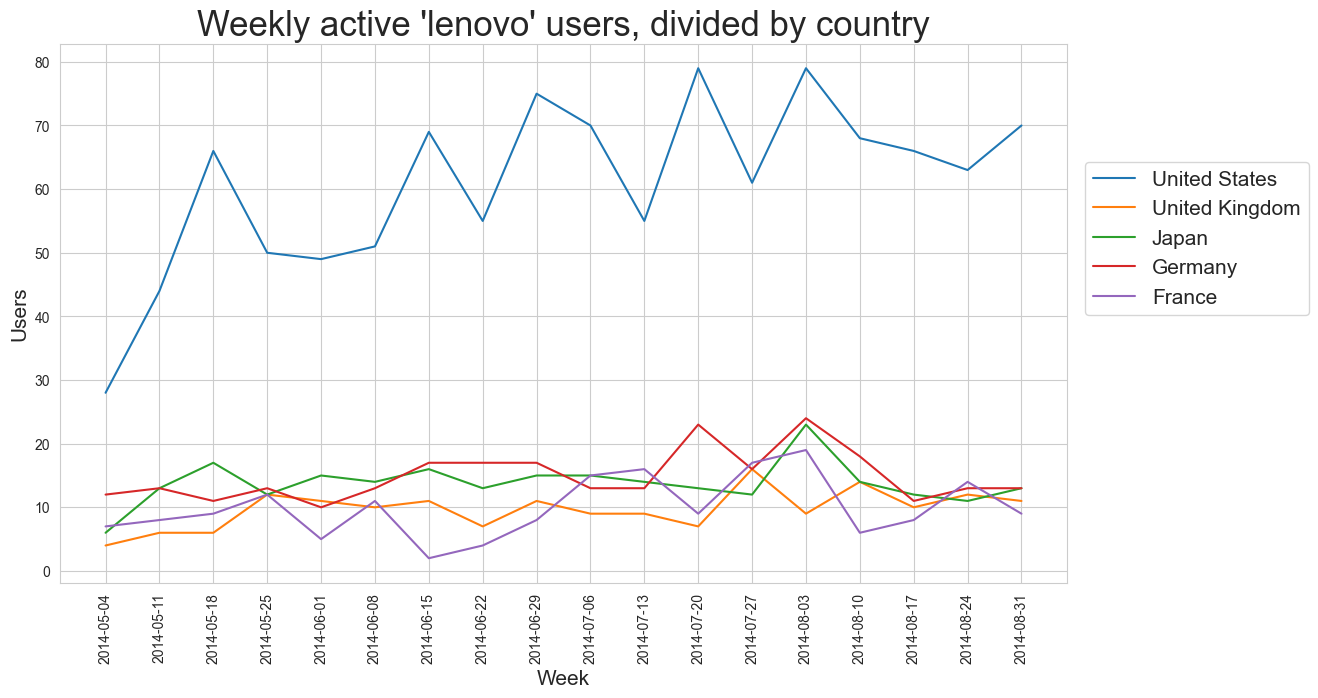

In [58]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active 'lenovo' users, divided by country", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=lenovo, y='n_users', x='week', hue='location')
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    plt.show()

For `lenovo` it's the same for every country.

### User type

Examine the impact of user type on engagement.

In [59]:
user_type = pd.read_sql('''
SELECT 
    DISTINCT user_type, 
    event_name, 
    event_type,
    COUNT(DISTINCT user_id) AS n_unique_users
FROM 
    events 
GROUP BY 
    1, 2,3
ORDER BY 
    1
''', conn)
user_type

,user_type,event_name,event_type,n_unique_users
0,0,create_user,signup_flow,7298
1,0,enter_email,signup_flow,4407
2,0,enter_info,signup_flow,3872
3,1,complete_signup,signup_flow,889
4,1,home_page,engagement,1785
5,1,like_message,engagement,1779
6,1,login,engagement,1785
7,1,search_autocomplete,engagement,1459
8,1,search_click_result_1,engagement,418
9,1,search_click_result_10,engagement,229


- It seems that `user_type=0` is for users who did not complete the registration process. Once you complete the signup process, you will be given a user type 1, 2 or 3. It may be assigned based on information from a user's profile, we don't know for sure. We don't care about it now.

Let's see weekly active users by user type.

In [60]:
user_type = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'weekday 0') AS week, 
    user_type, 
    COUNT(DISTINCT user_id) AS n_unique_users
FROM 
    events 
GROUP BY 
    1, 2
ORDER BY 
    1
''', conn)
user_type.head()

,week,user_type,n_unique_users
0,2014-05-04,0,171
1,2014-05-04,1,344
2,2014-05-04,2,155
3,2014-05-04,3,202
4,2014-05-11,0,350


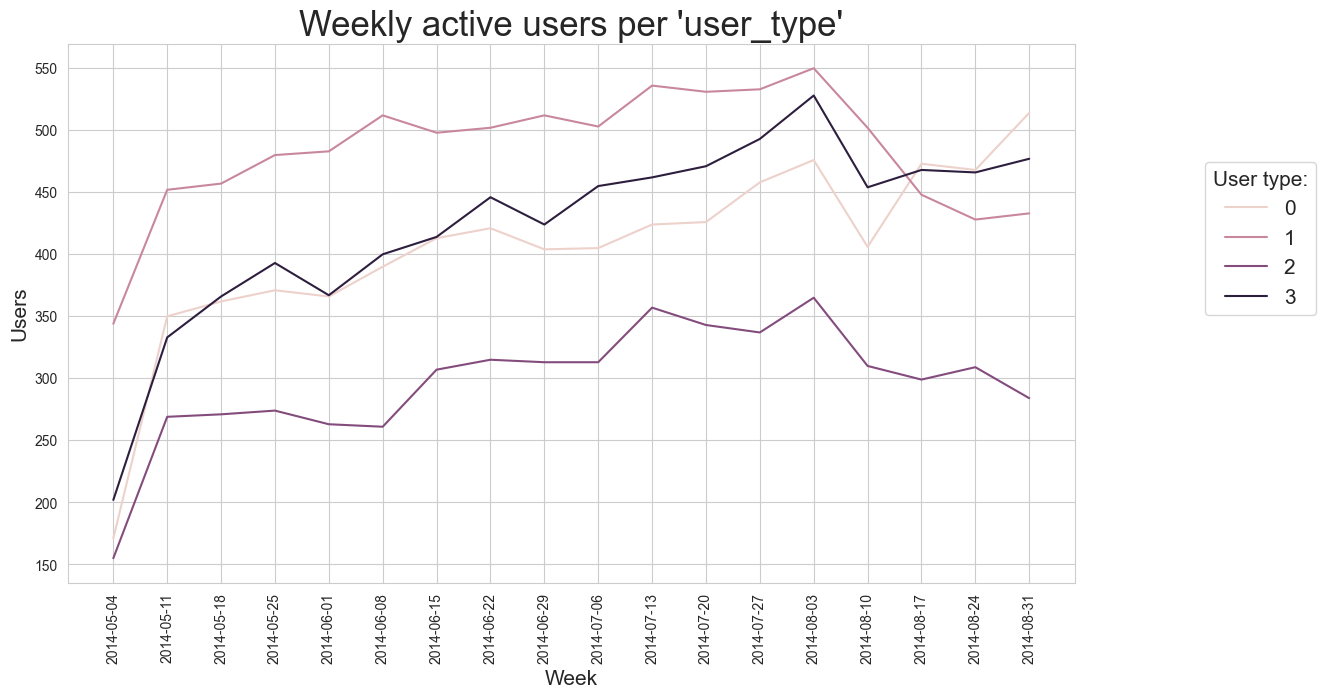

In [61]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly active users per 'user_type'", fontdict={'size':25})
    ax.set_ylabel("Users", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    ax = sns.lineplot(data=user_type, y='n_unique_users', x='week', hue='user_type')
    plt.legend(title='User type:', title_fontsize=15, 
               fontsize=15, loc='best', bbox_to_anchor=(0.75, 0., 0.5, 0.8))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

#### Conclusion

Since August, engagement has decreased for all types of users. But registration (`user_type=0`) has returned to growth after the dip.

# Emails

Can the problem have something to do with the emails that we send? Are all the users opening them and interacting in regular volumes?


Let's take a look at the `emails` table.

In [62]:
pd.read_sql('''
SELECT * FROM emails
''', conn).head()

,user_id,occurred_at,action,user_type
0,0,2014-05-06 09:30:00,sent_weekly_digest,1
1,0,2014-05-13 09:30:00,sent_weekly_digest,1
2,0,2014-05-20 09:30:00,sent_weekly_digest,1
3,0,2014-05-27 09:30:00,sent_weekly_digest,1
4,0,2014-06-03 09:30:00,sent_weekly_digest,1


In [63]:
pd.read_sql('''
SELECT 
    DISTINCT action 
FROM 
    emails
''', conn).head()

,action
0,sent_weekly_digest
1,email_open
2,email_clickthrough
3,sent_reengagement_email


In [64]:
emails_events = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'Weekday 0') AS week,
    COUNT(*) AS n_events,
    COUNT(DISTINCT(user_id)) AS n_unique_users
FROM 
    emails
GROUP BY 
    1
''', conn)
emails_events.head()

,week,n_events,n_unique_users
0,2014-05-04,1525,1006
1,2014-05-11,4119,2724
2,2014-05-18,4290,2801
3,2014-05-25,4405,2876
4,2014-06-01,4480,2945


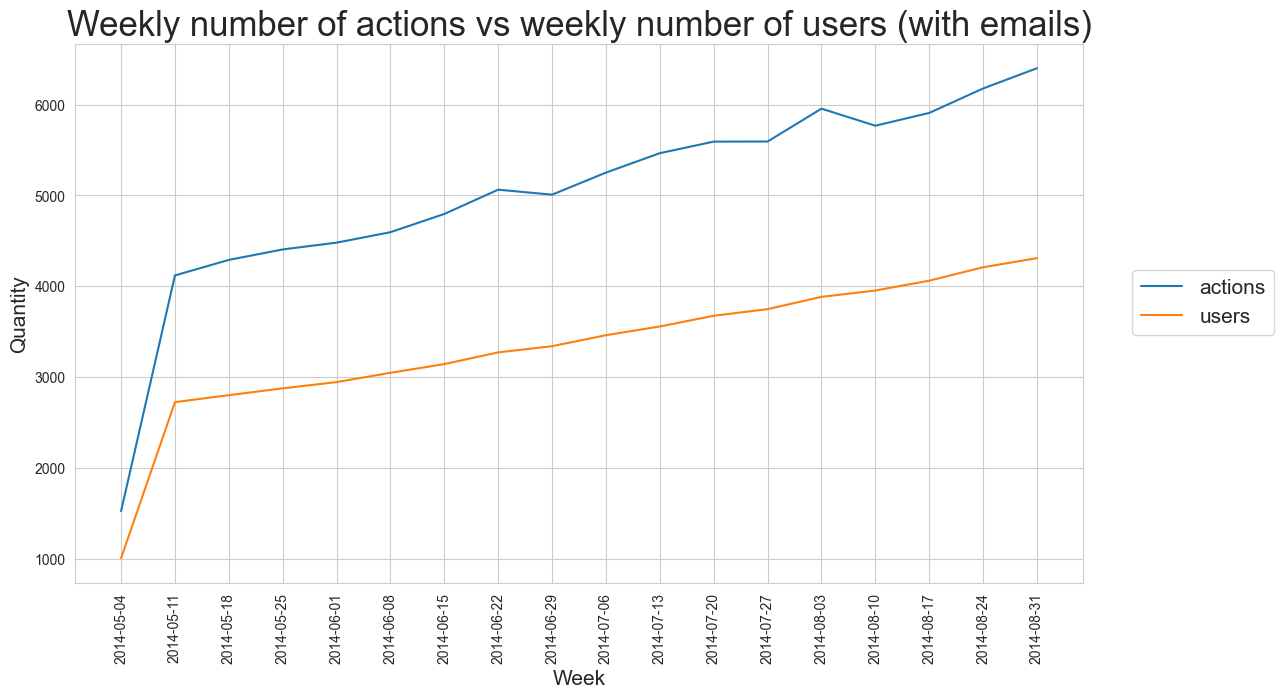

In [65]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly number of actions vs weekly number of users (with emails)", fontdict={'size':25})
    ax.set_ylabel("Quantity", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=emails_events, y='n_events', x='week', label='actions')
    ax = sns.lineplot(data=emails_events, y='n_unique_users', x='week', label ='users')
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.6))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

- It seems that the number of email actions is growing, but this is probably due to the growth of the number of new users.

We'll see what kind of action they take.

In [66]:
emails_events_per_action = pd.read_sql('''
SELECT 
    DATE(occurred_at, 'Weekday 0') AS week,
    action,
    COUNT(*) AS n_events,
    COUNT(DISTINCT(user_id)) AS n_unique_users
FROM 
    emails
GROUP BY 
    1,2
''', conn)
emails_events_per_action.head()

,week,action,n_events,n_unique_users
0,2014-05-04,email_clickthrough,187,187
1,2014-05-04,email_open,332,332
2,2014-05-04,sent_reengagement_email,98,98
3,2014-05-04,sent_weekly_digest,908,908
4,2014-05-11,email_clickthrough,434,431


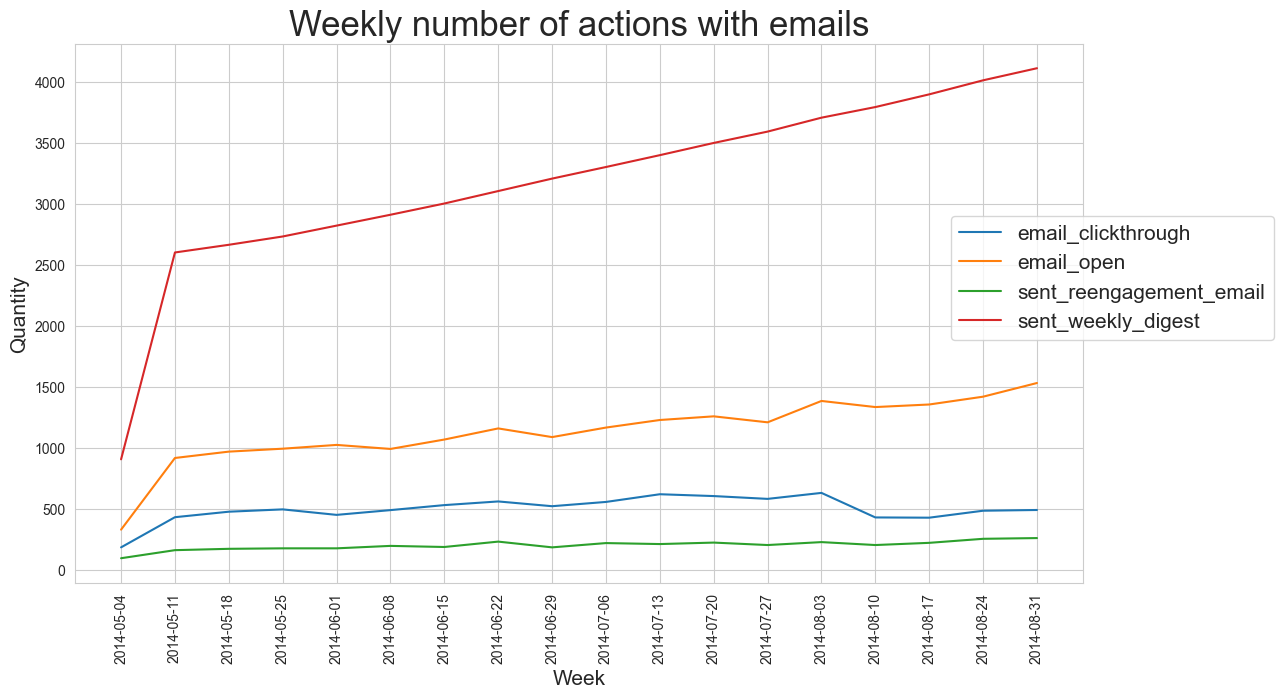

In [67]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(13,7))
    ax.set_title("Weekly number of actions with emails", fontdict={'size':25})
    ax.set_ylabel("Quantity", fontdict={'size':15})
    ax.set_xlabel("Week", fontdict={'size':15})
    
    ax = sns.lineplot(data=emails_events_per_action, y='n_events', x='week', hue='action')
    plt.legend(fontsize=15, loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.7))
    ax.set_xticklabels(events_week['week'], rotation=90, fontdict={'size':10})
    plt.show()

## Conclusion

Most of the actions with emails - are getting weekly digests. But only 30% of them are opened, and even fewer click through to the email. A small number of users receive reengagement emails, and they may not even open them.

# General conclusion

- We decided that the dip was primarily caused by two factors - the low quality of new users (unfinished registrations) and a drop in engagement among active users as a result of vacations.
- Additionally, we recommend the following:
    - Consider making the app more user-friendly by adding new features.
    - Check the latest iOS updates and perform UIX tests.
- While we work on that, we will wait and see if the spike was a one-time thing, or if it continues to return.
- To confirm our hypotheses about downsizing, we would also check some open sources with labor market data.
- Would be great to get more fast growing startups to gain more active users who need actively interact with each other. 